In [3]:
from pathlib import Path as pt
import umap
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from typing import List
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm.notebook import tqdm as tqdm_notebook

warnings.filterwarnings('ignore')
tqdm.pandas()

In [1]:
from load_data import processed_data_dirs, plots_dir, property_units, property_names, titles
from umda_viz import ChemicalClusterAnalyzer
processed_data_dirs

[PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tbp_C_processed_data/analysis_data/filtered/tbp_topelements_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/vp_kPa_25C_filtered_ydata_processed_data/analysis_data/filtered/vp_kPa_25C_topelements_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/[CRITICAL CONSTANTS OF ORGANIC COMPOUNDS]/Pc_MPa_processed_data'),
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology

In [ ]:
def add_cluster_annotations(fig: go.Figure, df_plot: pd.DataFrame, labels: np.ndarray) -> go.Figure:
    # Optional: Add cluster centers with their statistics
    for cluster_id in set(labels):
        if cluster_id != -1:  # Skip noise points
            cluster_mask = df_plot['Cluster'] == cluster_id
            cluster_data = df_plot[cluster_mask]
            
            # Calculate cluster center and mean melting point
            center_x = cluster_data['UMAP1'].mean()
            center_y = cluster_data['UMAP2'].mean()
            mean_mp = cluster_data['molecular_property'].mean()
            std_mp = cluster_data['molecular_property'].std()
            
            # Add annotation for cluster statistics
            fig.add_annotation(
                x=center_x,
                y=center_y,
                text=f"Cluster {cluster_id}<br>MP: {mean_mp:.1f}±{std_mp:.1f}",
                showarrow=True,
                arrowhead=1,
                bgcolor='rgba(255,255,255,0.8)',
                bordercolor='black',
                borderwidth=1
            )
    return fig

def export_plotly_data(
        reduced_embeddings: np.ndarray, 
        labels: np.ndarray, 
        y: np.ndarray, 
        smiles_list: List[str], 
        property_name_with_unit: str, 
        # property_name: str,
        output_file: str
    ) -> None:
    """
    Export the plot data as JSON for use with Plotly.js
    
    Args:
        reduced_embeddings: UMAP embeddings array of shape (n_samples, 2)
        labels: Cluster labels array
        y: Molecular property values array
        smiles_list: List of SMILES strings
        property_name_with_unit: Property name with unit for display
        property_name: Property name without unit
        output_file: Path to save the JSON file
    """
    
    # Calculate statistics
    stats = {
        "mean": float(np.mean(y)),
        "std": float(np.std(y)),
        "min": float(np.min(y)),
        "max": float(np.max(y))
    }
    
    # Create the plot data structure
    plot_data = {
        "data": [{
            "type": "scatter",
            "x": reduced_embeddings[:, 0].tolist(),
            "y": reduced_embeddings[:, 1].tolist(),
            "mode": "markers",
            "marker": {
                "size": 8,
                "color": y.tolist(),
                "colorscale": "Viridis",
                "colorbar": {
                    "title": property_name_with_unit
                },
                "showscale": True
            },
            "text": [
                f"SMILES: {s}<br>{property_name_with_unit}: {v:.2f}<br>Cluster: {c}"
                for s, v, c in zip(smiles_list, y, labels)
            ],
            "hoverinfo": "text"
        }],
        "layout": {
            "title": f"Chemical Structure Space Colored by {property_name_with_unit}",
            "template": "plotly_white",
            "width": 1200,
            "height": 800,
            "showlegend": False,
            "hovermode": "closest",
            "xaxis": {"title": "UMAP1"},
            "yaxis": {"title": "UMAP2"},
            "annotations": [{
                "x": 0.02,
                "y": 0.98,
                "xref": "paper",
                "yref": "paper",
                "text": (
                    f"{property_name_with_unit} Statistics:<br>"
                    f"Mean: {stats['mean']:.2f}<br>"
                    f"Std: {stats['std']:.2f}<br>"
                    f"Min: {stats['min']:.2f}<br>"
                    f"Max: {stats['max']:.2f}"
                ),
                "showarrow": False,
                "font": {"size": 12},
                "bgcolor": "white",
                "bordercolor": "black",
                "borderwidth": 1,
                "align": "left"
            }]
        }
    }
    
    return plot_data
    
    # # Save to JSON file
    # output_path = Path(output_file)
    # with open(output_path, 'w') as f:
    #     json.dump(plot_data, f, indent=2)
    
    # print(f"Plot data saved to: {output_path}")

def plot_figure(
        reduced_embeddings: np.ndarray, 
        labels: np.ndarray, 
        y: np.ndarray, 
        smiles_list: List[str], 
        property_name_with_unit: str, 
        property_name:str, 
        fname: str,
        save: bool = False
    ) -> go.Figure:
    
    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'Cluster': labels,
        'SMILES': smiles_list,
        'molecular_property': y  # Adding melting point values
    })

    # Optional: Add statistical analysis
    print(f"\nStatistical Analysis of {property_name_with_unit} by Cluster:")
    cluster_stats = []
    for cluster_id in sorted(set(labels)):
        if cluster_id != -1:
            cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
            stats = {
                'Cluster': cluster_id,
                'Size': len(cluster_data),
                'Mean_MP': cluster_data['molecular_property'].mean(),
                'Std_MP': cluster_data['molecular_property'].std(),
                'Min_MP': cluster_data['molecular_property'].min(),
                'Max_MP': cluster_data['molecular_property'].max()
            }
            cluster_stats.append(stats)

    stats_df = pd.DataFrame(cluster_stats)
    print("\nCluster Statistics:")
    print(stats_df.round(2))

    # Create figure
    fig = go.Figure()

    # Create a continuous color scale
    colorscale = 'Viridis'  # You can also try 'RdBu', 'Jet', 'Turbo', etc.

    # Add all points in a single scatter plot for continuous color mapping
    fig.add_trace(go.Scatter(
        x=df_plot['UMAP1'],
        y=df_plot['UMAP2'],
        mode='markers',
        marker=dict(
            size=8,
            color=df_plot['molecular_property'],
            colorscale=colorscale,
            colorbar=dict(title=property_name_with_unit),
            showscale=True
        ),
        text=[
            f"SMILES: {s}<br>" +
            f"{property_name}: {mp:.2f}<br>" +
            f"Cluster: {c}"
            for s, mp, c in zip(df_plot['SMILES'], df_plot['molecular_property'], df_plot['Cluster'])
        ],
        hoverinfo='text'
    ))

    # Update layout
    fig.update_layout(
        title=f'Chemical Structure Space Colored by {property_name_with_unit}',
        template='plotly_white',
        width=1200,
        height=800,
        showlegend=False,
        hovermode='closest',
        xaxis_title='UMAP1',
        yaxis_title='UMAP2'
    )

    # Add a text annotation with statistics
    mp_stats = f"""
    {property_name_with_unit} Statistics:
    Mean: {y.mean():.2f}
    Std: {y.std():.2f}
    Min: {y.min():.2f}
    Max: {y.max():.2f}
    """

    fig.add_annotation(
        x=0.02,
        y=0.98,
        xref='paper',
        yref='paper',
        text=mp_stats,
        showarrow=False,
        font=dict(size=12),
        bgcolor='white',
        bordercolor='black',
        borderwidth=1,
        align='left'
    )

    # fig = add_cluster_annotations(fig, df_plot, labels)

    # save = True
    # save = False

    if save:
        save_path = plots_dir / f'{fname}_umap_property.html'
        fig.write_html(save_path)
        print(f"Property visualization saved to: {save_path}")

    fig.show()
    
    return fig

In [90]:
def compute_umap(ind: int):
    embeddings = 'mol2vec'
    property_name = property_names[ind]
    property_unit = property_units[ind]
    title = titles[ind]
    property_name_with_unit = f'{property_name} ({property_unit})'
    print(property_name_with_unit, title)

    current_dir = processed_data_dirs[ind]
    fname = current_dir.name.replace('_processed_data', '')
    csv_file = current_dir.parent / f'{fname}.csv'
    print(csv_file.exists(), csv_file.name)

    vec_dir = current_dir / f'embedded_vectors/processed_{embeddings}_embeddings'
    print(vec_dir.exists(), vec_dir.name)
    
    df = pd.read_parquet(vec_dir / 'processed_df.parquet')
    smiles_list = df['SMILES'].to_list()
    print(len(smiles_list), 'smiles')
    
    X = df.iloc[:, 2:].to_numpy()
    y = df["y"].to_numpy()
    print(X.shape, y.shape)

    # Scale embeddings
    print("Scaling embeddings...")
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(X)

    # Perform UMAP
    print("Performing UMAP...")

    n_neighbors = 15
    min_dist = 0.1
    n_components = 2

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_jobs=-1,
        # random_state=random_state
    )
        
    reduced_embeddings = reducer.fit_transform(scaled_embeddings)
    print(reduced_embeddings.shape)

    cluster_eps: float = 0.5
    cluster_min_samples: int = 5

    print("Analyzing chemical clusters...")
    analyzer = ChemicalClusterAnalyzer()
    labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
        reduced_embeddings,
        smiles_list,
        eps=cluster_eps,
        min_samples=cluster_min_samples
    )
    
    return reduced_embeddings, labels, cluster_analysis, y, smiles_list, property_name_with_unit, property_name, fname

ind = 0
print(f'Processing {ind}')
reduced_embeddings, labels, cluster_analysis, y, smiles_list, property_name_with_unit, property_name, fname = compute_umap(ind)
fig = plot_figure(
    reduced_embeddings=reduced_embeddings,
    labels=labels,
    y=y,
    smiles_list=smiles_list,
    property_name_with_unit=property_name_with_unit,
    property_name=property_name,
    fname=fname,
    # save=True
)
# fig.show()

Processing 0
Melting Point (K) MP
True tmpC_topelements.csv
True processed_mol2vec_embeddings
7476 smiles
(7476, 300) (7476,)
Scaling embeddings...
Performing UMAP...
(7476, 2)
Analyzing chemical clusters...


100%|██████████| 19/19 [00:01<00:00, 15.39it/s]



Statistical Analysis of Melting Point (K) by Cluster:

Cluster Statistics:
    Cluster  Size  Mean_MP  Std_MP  Min_MP  Max_MP
0         0  1573   146.67   84.60  -30.43   492.0
1         1  1268   119.46   99.42 -177.20   400.0
2         2  1759    93.82   89.63  -99.52   410.0
3         3    81    66.22   62.31  -56.40   309.0
4         4  2174    29.16   99.24 -205.10   335.0
5         5    70   107.60   46.58   25.80   205.0
6         6    37   205.26   75.89   37.00   420.0
7         7    16   172.09  111.70   40.00   485.0
8         8    25   -12.05   52.21 -101.30    94.0
9         9    16   135.39   49.94   69.00   230.4
10       10    18    37.76   38.20  -14.87   168.5
11       11    68    75.16   66.89  -45.10   224.0
12       12   211   101.46   70.98  -92.70   303.0
13       13    20   138.15   78.35   46.50   329.0
14       14    77    69.11   64.05  -57.84   213.5
15       15    12   255.33   40.61  214.00   350.0
16       16    16   187.12   33.67  147.00   286.0
17    

In [48]:
cluster_analysis_df = pd.DataFrame(cluster_analysis).T
# set the first col as index and name it label
cluster_analysis_df.index.name = 'label'
cluster_analysis_df

,size,functional_groups,center
label,,,
0,1581,"{'Aromatic': 0.9860847564832385, 'Alcohol': 0....","[-3.486943, 7.349368]"
1,1188,"{'Alcohol': 0.4166666666666667, 'Carboxylic Ac...","[1.952765, 8.5267105]"
2,1690,"{'Alcohol': 0.3769230769230769, 'Ether': 0.222...","[-1.285479, 0.7413936]"
3,79,"{'Amide': 0.12658227848101267, 'Alcohol': 0.18...","[7.125958, 1.288996]"
4,2193,"{'Aldehyde': 0.015503875968992248, 'Alcohol': ...","[12.508586, 4.295905]"
5,70,"{'Amine': 0.22857142857142856, 'Aromatic': 0.9...","[10.711085, -2.5168238]"
6,25,"{'Alcohol': 1.0, 'Aldehyde': 0.6, 'Amide': 0.1...","[4.814452, 10.08624]"
7,48,"{'Alcohol': 1.0, 'Ether': 0.9166666666666666, ...","[4.00592, 10.421424]"
8,37,"{'Ester': 0.16216216216216217, 'Ether': 0.2432...","[12.32591, 9.821981]"


In [35]:
cluster_analysis_df.loc[0, 'functional_groups']

{'Aromatic': 0.9860847564832385,
 'Alcohol': 0.2890575585072739,
 'Ether': 0.18722327640733713,
 'Amide': 0.06388361796331436,
 'Alkene': 0.07273877292852625,
 'Ketone': 0.12017710309930424,
 'Carboxylic Acid': 0.0777988614800759,
 'Halogen': 0.20619860847564833,
 'Amine': 0.1644528779253637,
 'Ester': 0.06767868437697659,
 'Sulfonic Acid': 0.013282732447817837,
 'Nitrile': 0.011385199240986717,
 'Aldehyde': 0.0056925996204933585,
 'Alkyne': 0.0018975332068311196}

In [38]:
cluster_analysis

{0: {'size': 1581,
  'functional_groups': {'Aromatic': 0.9860847564832385,
   'Alcohol': 0.2890575585072739,
   'Ether': 0.18722327640733713,
   'Amide': 0.06388361796331436,
   'Alkene': 0.07273877292852625,
   'Ketone': 0.12017710309930424,
   'Carboxylic Acid': 0.0777988614800759,
   'Halogen': 0.20619860847564833,
   'Amine': 0.1644528779253637,
   'Ester': 0.06767868437697659,
   'Sulfonic Acid': 0.013282732447817837,
   'Nitrile': 0.011385199240986717,
   'Aldehyde': 0.0056925996204933585,
   'Alkyne': 0.0018975332068311196},
  'center': array([-3.486943,  7.349368], dtype=float32)},
 1: {'size': 1188,
  'functional_groups': {'Alcohol': 0.4166666666666667,
   'Carboxylic Acid': 0.0664983164983165,
   'Alkene': 0.35353535353535354,
   'Ketone': 0.20202020202020202,
   'Amide': 0.15404040404040403,
   'Aromatic': 0.3434343434343434,
   'Ether': 0.382996632996633,
   'Ester': 0.1473063973063973,
   'Aldehyde': 0.015151515151515152,
   'Amine': 0.11616161616161616,
   'Halogen': 0.06

In [ ]:
vec_processed_dir = pt('/Users/aravindhnivas/Documents/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data/embedded_vectors/processed_mol2vec_embeddings')
umap_dir = vec_processed_dir / 'umap'

label_issues_df = pd.read_parquet(vec_processed_dir / 'label_issues_xgboost.parquet')
processed_df = pd.read_parquet(vec_processed_dir / 'processed_df.parquet')
# label_issues_df
cleaned_label_df = label_issues_df[~label_issues_df['is_label_issue']]
cleaned_label_df
# umap_df = pd.read_parquet(umap_dir / 'umap_df.parquet')
# umap_df

,is_label_issue,label_quality,given_label,predicted_label
INDEX,,,,
0,False,0.657032,31.6,43.800186
1,False,0.616832,173.5,157.887009
2,False,0.345449,160.0,124.968880
3,False,0.629690,263.0,249.491867
4,False,0.531863,121.0,102.297394
...,...,...,...,...
7633,False,0.192307,286.0,240.885727
7634,False,0.965621,210.0,211.010986
7635,False,0.943607,99.0,100.677544


In [72]:
label_issues_df = pd.read_parquet(vec_processed_dir / 'label_issues_xgboost.parquet')
print(f"Label issues: {label_issues_df.shape}")

cleaned_label_df = label_issues_df[~label_issues_df["is_label_issue"]]
cleaned_df = processed_df.loc[cleaned_label_df.index]
if (cleaned_df.index == cleaned_label_df.index).all():
    # df = processed_df[~label_issues_df["is_label_issue"]]
    processed_df = cleaned_df
print(f"Cleaned DataFrame: {cleaned_df.shape}")
print(f"Processed DataFrame: {processed_df.shape}")

Label issues: (7476, 4)
Cleaned DataFrame: (6167, 302)
Processed DataFrame: (6167, 302)


In [69]:
cleaned_label_df.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7638],
      dtype='int64', name='INDEX', length=6167)

In [50]:
cluster_analysis_df = pd.read_parquet(umap_dir / "cluster_analysis.parquet")
cluster_analysis_df

,size,functional_groups,center,Mean,Std,Min,Max
0,1660,"{'Alcohol': 0.2921686746987952, 'Aldehyde': 0....","[-3.4948177, 6.8615427]",148.797466,83.990404,-30.43,492.0
1,1074,"{'Alcohol': 0.3845437616387337, 'Aldehyde': 0....","[1.6691883, 7.2991996]",106.067689,100.959767,-177.20,400.0
2,1691,"{'Alcohol': 0.38024837374334713, 'Aldehyde': 0...","[-0.24010327, -1.2182803]",90.220432,89.865361,-101.30,410.0
3,80,"{'Alcohol': 0.2, 'Aldehyde': 0.0125, 'Alkene':...","[6.425209, 2.5931027]",65.065000,61.827001,-56.40,309.0
4,1978,"{'Alcohol': 0.28412537917087965, 'Aldehyde': 0...","[11.745186, 5.12557]",28.773766,99.187030,-205.10,328.0
5,71,"{'Alcohol': 0.2676056338028169, 'Aldehyde': No...","[-3.8292236, 0.9590293]",140.676056,86.624169,4.50,357.0
6,228,"{'Alcohol': 0.3684210526315789, 'Aldehyde': 0....","[13.663157, -0.06833662]",34.331140,92.655955,-137.36,335.0
7,70,"{'Alcohol': 0.2714285714285714, 'Aldehyde': 0....","[11.619695, -2.2978406]",107.595714,46.580964,25.80,205.0
8,21,"{'Alcohol': 1.0, 'Aldehyde': 0.619047619047619...","[6.6721854, 6.7948375]",138.919048,39.104931,90.00,255.0
9,23,"{'Alcohol': 1.0, 'Aldehyde': 0.130434782608695...","[3.5685034, 8.24012]",164.352174,39.100673,80.00,236.0


In [53]:
umap_df = pd.read_parquet(umap_dir / 'umap_df.parquet')
umap_df

,INDEX,UMAP1,UMAP2,Cluster,SMILES,y
0,0,-4.179025,9.977406,0,COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1,31.6
1,1,1.152093,8.777915,1,CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1,173.5
2,2,1.259044,8.010041,1,CC(C=CC1(O)C(C)=CC(=O)CC1(C)C)=CC(=O)O,160.0
3,3,-2.735888,8.698898,0,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1,263.0
4,4,0.862543,0.822777,2,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,121.0
...,...,...,...,...,...,...
7471,7635,0.297855,0.010990,2,CNC(=O)Oc1cc(C)cc(C)c1,99.0
7472,7636,-0.499817,8.715023,20,COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21,241.0
7473,7637,-0.480009,8.718947,20,COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21.Cl,302.0
7474,7638,-1.479428,8.776973,0,CC1CCCC(=O)CCCC=Cc2cc(O)cc(O)c2C(=O)O1,164.0


In [28]:
reduced_embeddings, labels, cluster_analysis, y, smiles_list, property_name_with_unit, property_name, fname = compute_umap(4)
fig = plot_figure(
    reduced_embeddings=reduced_embeddings,
    labels=labels,
    y=y,
    smiles_list=smiles_list,
    property_name_with_unit=property_name_with_unit,
    property_name=property_name,
    fname=fname,
    save=True
)

Critical Temperature (K) CT
True Tc_K.csv
819 smiles
True processed_mol2vec_embeddings
(819, 300) (819,)
Scaling embeddings...
Performing UMAP...
(819, 2)
Analyzing chemical clusters...


100%|██████████| 9/9 [00:00<00:00, 69.14it/s]


Statistical Analysis of Critical Temperature (K) by Cluster:

Cluster Statistics:
   Cluster  Size  Mean_MP  Std_MP  Min_MP  Max_MP
0        0   451   573.06  131.55  190.56   872.0
1        1   105   702.96   69.32  490.20   886.0
2        2    24   822.58   78.53  750.00  1115.0
3        3    40   617.23   86.66  398.20   787.0
4        4    41   599.10   47.14  516.40   685.7
5        5   105   577.44   62.61  407.81   850.0
6        6    43   554.80   52.16  433.71   708.0
7        7     9   428.03   48.44  361.80   486.5
Property visualization saved to: /Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/Tc_K_umap_property.html


In [41]:
def plot_figure_static(
    reduced_embeddings: np.ndarray, 
    labels: np.ndarray, 
    y: np.ndarray, 
    smiles_list: List[str], 
    property_name_with_unit: str, 
    property_name: str, 
    fname: str,
    save: bool = False,
    fig_size: tuple = (12, 8),
    point_size: int = 50,
    alpha: float = 0.6
) -> plt.Figure:
    """
    Create a static visualization of UMAP embeddings colored by molecular property using seaborn.
    """
    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'Cluster': labels,
        'SMILES': smiles_list,
        'molecular_property': y
    })

    # Set up the matplotlib figure
    plt.clf()
    fig, ax = plt.subplots(figsize=fig_size)

    # Create the scatter plot using seaborn
    scatter = sns.scatterplot(
        data=df_plot,
        x='UMAP1',
        y='UMAP2',
        hue='molecular_property',
        palette='viridis',
        s=point_size,
        alpha=alpha,
        ax=ax
    )

    # Remove the automatic legend created by seaborn
    scatter.legend_.remove()

    # Create and customize the colorbar
    norm = plt.Normalize(y.min(), y.max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax)  # Pass the axis to the colorbar
    colorbar.set_label(property_name_with_unit, fontsize=12)

    # Add title and labels
    ax.set_title(f'Chemical Structure Space Colored by {property_name_with_unit}', 
                fontsize=14, pad=20)
    ax.set_xlabel('UMAP1', fontsize=12)
    ax.set_ylabel('UMAP2', fontsize=12)

    # Add statistics annotation
    stats_text = (f"{property_name_with_unit} Statistics:\n"
                 f"Mean: {y.mean():.2f}\n"
                 f"Std: {y.std():.2f}\n"
                 f"Min: {y.min():.2f}\n"
                 f"Max: {y.max():.2f}")
    
    # Position the text box in figure coords
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(1.2, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=props)

    # # Optional: Add cluster centers and labels
    # for cluster_id in set(labels):
    #     if cluster_id != -1:
    #         cluster_mask = df_plot['Cluster'] == cluster_id
    #         cluster_data = df_plot[cluster_mask]
    #         center_x = cluster_data['UMAP1'].mean()
    #         center_y = cluster_data['UMAP2'].mean()
    #         mean_prop = cluster_data['molecular_property'].mean()
            
    #         # Add cluster label with mean property value
    #         # ax.annotate(f'Cluster {cluster_id}\n{mean_prop:.1f}',
    #         ax.annotate(f'{cluster_id}',
    #                    (center_x, center_y),
    #                    xytext=(5, 5),
    #                    textcoords='offset points',
    #                    fontsize=8,
    #                 #    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    #                    )

    # Tight layout to prevent text clipping
    plt.tight_layout()

    # Save if requested
    if save:
        save_path = plots_dir / f'{fname}_umap_property_static.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Property visualization saved to: {save_path}")

    return fig


# results = compute_umap(0)
# reduced_embeddings, labels, cluster_analysis, y, smiles_list, property_name_with_unit, property_name, fname = results
# static_fig = plot_figure_static(
#     reduced_embeddings=reduced_embeddings,
#     labels=labels,
#     y=y,
#     smiles_list=smiles_list,
#     property_name_with_unit=property_name_with_unit,
#     property_name=property_name,
#     fname=fname,
#     save=True
# )
# plt.show()



<Figure size 640x480 with 0 Axes>

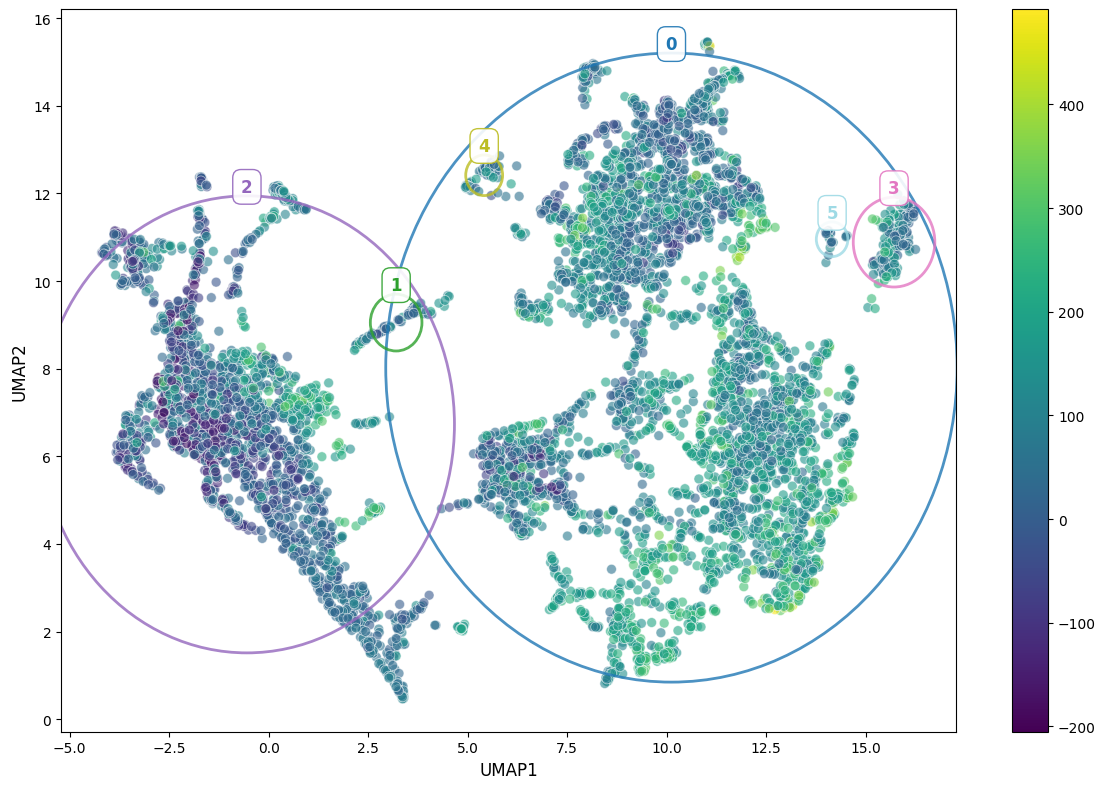

In [89]:
# Set up the matplotlib figure
umap_df = pd.read_parquet(
    umap_dir / '[umap_df]_tmpC_topelements_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
)

def plot_figure_static(
    df_plot: pd.DataFrame,
    fig_size: tuple = (12, 8),
    point_size: int = 50,
    alpha: float = 0.6,
) -> plt.Figure:
    """
    Create a static visualization with minimal cluster labels
    """
    plt.clf()
    fig, ax = plt.subplots(figsize=fig_size)

    # Create the scatter plot using seaborn
    scatter = sns.scatterplot(
        data=df_plot,
        x="UMAP1",
        y="UMAP2",
        hue="y",
        palette="viridis",
        s=point_size,
        alpha=alpha,
        ax=ax,
    )

    # Remove the automatic legend
    scatter.legend_.remove()

    # Create and customize the colorbar
    norm = plt.Normalize(df_plot["y"].min(), df_plot["y"].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax)

    # Define distinct colors for clusters
    cluster_colors = plt.cm.tab20(np.linspace(0, 1, len(df_plot['Cluster'].unique())))

    # Add cluster circles and labels
    for idx, cluster_id in enumerate(sorted(df_plot['Cluster'].unique())):
        if cluster_id == -1:  # Skip noise points
            continue
            
        # Get points for this cluster
        cluster_points = df_plot[df_plot['Cluster'] == cluster_id]
        
        # Calculate cluster center
        center_x = cluster_points['UMAP1'].mean()
        center_y = cluster_points['UMAP2'].mean()
        
        # Calculate cluster radius
        std_x = cluster_points['UMAP2'].std() * 2
        std_y = cluster_points['UMAP2'].std() * 2
        radius = max(std_x, std_y)
        
        # Get color for this cluster
        cluster_color = cluster_colors[idx]
        
        # Draw circle around cluster
        circle = plt.Circle(
            (center_x, center_y),
            radius,
            fill=False,
            linestyle='-',
            color=cluster_color,
            alpha=0.8,
            linewidth=2
        )
        ax.add_patch(circle)
        
        # Add just the cluster ID at the circle's boundary
        # Calculate position on the circle's circumference (top of circle)
        label_x = center_x
        label_y = center_y + radius
        
        # Add cluster label with white background for better visibility
        ax.text(label_x, label_y, str(cluster_id),
                horizontalalignment='center',
                verticalalignment='bottom',
                color=cluster_color,
                fontweight='bold',
                fontsize=12,
                bbox=dict(facecolor='white', 
                         edgecolor=cluster_color,
                         alpha=0.9,
                         pad=0.5,
                         boxstyle='round'))

    ax.set_xlabel("UMAP1", fontsize=12)
    ax.set_ylabel("UMAP2", fontsize=12)
    
    plt.tight_layout()
    return fig

fig = plot_figure_static(umap_df)
plt.show()

In [43]:
for ind in range(5):
    results = compute_umap(ind)
    reduced_embeddings, labels, cluster_analysis, y, smiles_list, property_name_with_unit, property_name, fname = results
    static_fig = plot_figure_static(
        reduced_embeddings=reduced_embeddings,
        labels=labels,
        y=y,
        smiles_list=smiles_list,
        property_name_with_unit=property_name_with_unit,
        property_name=property_name,
        fname=fname,
        save=True
    )
    # plt.show()
    plt.close()

Melting Point (K) MP
True tmpC_topelements.csv
7476 smiles
True processed_mol2vec_embeddings
(7476, 300) (7476,)
Scaling embeddings...
Performing UMAP...
(7476, 2)
Analyzing chemical clusters...


100%|██████████| 23/23 [00:01<00:00, 19.01it/s]


Property visualization saved to: /Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/tmpC_topelements_umap_property_static.png
Boiling Point (K) BP
True tbp_topelements.csv
4915 smiles
True processed_mol2vec_embeddings
(4915, 300) (4915,)
Scaling embeddings...
Performing UMAP...
(4915, 2)
Analyzing chemical clusters...


100%|██████████| 20/20 [00:00<00:00, 26.87it/s]


Property visualization saved to: /Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/tbp_topelements_umap_property_static.png
Vapor Pressure (kPa at 25°C ) VP
True vp_kPa_25C_topelements.csv
398 smiles
True processed_mol2vec_embeddings
(398, 300) (398,)
Scaling embeddings...
Performing UMAP...
(398, 2)
Analyzing chemical clusters...


100%|██████████| 7/7 [00:00<00:00, 111.77it/s]


Property visualization saved to: /Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/vp_kPa_25C_topelements_umap_property_static.png
Critical Pressure (MPa) CP
True Pc_MPa.csv
777 smiles
True processed_mol2vec_embeddings
(777, 300) (777,)
Scaling embeddings...
Performing UMAP...
(777, 2)
Analyzing chemical clusters...


100%|██████████| 10/10 [00:00<00:00, 84.10it/s]


Property visualization saved to: /Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/Pc_MPa_umap_property_static.png
Critical Temperature (K) CT
True Tc_K.csv
819 smiles
True processed_mol2vec_embeddings
(819, 300) (819,)
Scaling embeddings...
Performing UMAP...
(819, 2)
Analyzing chemical clusters...


100%|██████████| 9/9 [00:00<00:00, 68.05it/s]


Property visualization saved to: /Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots/Tc_K_umap_property_static.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Cluster': labels,
    'SMILES': smiles_list
})

# Create interactive plot
fig = go.Figure()

# Add scatter points for each cluster
for cluster_id in set(labels):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    
    # Get dominant functional groups for hover text
    if cluster_id in cluster_analysis:
        top_groups = sorted(
            cluster_analysis[cluster_id]['functional_groups'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        hover_text = [
            f"SMILES: {s}<br>Cluster: {cluster_id}<br>" +
            "<br>".join([f"{g}: {v:.1%}" for g, v in top_groups])
            for s in cluster_data['SMILES']
        ]
    else:
        hover_text = [f"SMILES: {s}<br>Cluster: Noise" for s in cluster_data['SMILES']]
    
    fig.add_trace(go.Scatter(
        x=cluster_data['UMAP1'],
        y=cluster_data['UMAP2'],
        mode='markers',
        name=f'Cluster {cluster_id}',
        text=hover_text,
        hoverinfo='text',
        marker=dict(size=8)
    ))

# Update layout
fig.update_layout(
    title='Chemical Structure Clusters Analysis',
    template='plotly_white',
    width=1200,
    height=800,
    showlegend=True,
    hovermode='closest'
)
save_path = plots_dir / f'{fname}_umap_clusters.html'
fig.write_html(save_path)
print(f"Cluster analysis plot saved to: {save_path}")
fig.show()

In [ ]:
# Optional: Create a second visualization showing both property and clusters
fig2 = go.Figure()

# Create subplots for different clusters with continuous color mapping
for cluster_id in set(labels):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    
    name = 'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'
    
    fig2.add_trace(go.Scatter(
        x=cluster_data['UMAP1'],
        y=cluster_data['UMAP2'],
        mode='markers',
        name=name,
        marker=dict(
            size=8,
            color=cluster_data['Melting_Point'],
            colorscale=colorscale,
            showscale=True if cluster_id == list(set(labels))[-1] else False,  # Show colorbar only once
            colorbar=dict(title=property_name)
        ),
        text=[
            f"SMILES: {s}<br>" +
            f"{property_name}: {mp:.2f}<br>" +
            f"Cluster: {c}"
            for s, mp, c in zip(cluster_data['SMILES'], 
                              cluster_data['Melting_Point'], 
                              cluster_data['Cluster'])
        ],
        hoverinfo='text'
    ))

fig2.update_layout(
    title=f'Chemical Structure Clusters with {property_name} Distribution',
    template='plotly_white',
    width=1200,
    height=800,
    showlegend=True,
    hovermode='closest',
    xaxis_title='UMAP1',
    yaxis_title='UMAP2'
)

# fig2.show()

# Add melting point statistics per cluster
stats_text = f"{property_name} by Cluster:\n"
for cluster_id in sorted(set(labels)):
    if cluster_id != -1:
        cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
        stats_text += f"\nCluster {cluster_id}:\n"
        stats_text += f"Mean: {cluster_data['Melting_Point'].mean():.2f}\n"
        stats_text += f"Std: {cluster_data['Melting_Point'].std():.2f}\n"

fig2.add_annotation(
    x=1.15,
    y=0.5,
    xref='paper',
    yref='paper',
    text=stats_text,
    showarrow=False,
    font=dict(size=10),
    align='left'
)

# save_path2 = plots_dir / f'{fname}_umap_property_clusters.html'
# fig2.write_html(save_path2)
# print(f"Property and clusters visualization saved to: {save_path2}")
# fig2.show()

In [ ]:
import matplotlib.colors as mcolors

colors = list(mcolors.XKCD_COLORS.keys())

fig, ax = plt.subplots(figsize=(15, 8), dpi=200)

for cluster_id in cluster_analysis.keys():
    cluster_data = cluster_analysis[cluster_id]

    top_groups = sorted(
        cluster_analysis[cluster_id]['functional_groups'].items(),
        key=lambda x: x[1],
        reverse=True
    )[:3]
    # print(cluster_id, top_groups)
    
    legend_text = f"{cluster_id}: "
    for group, freq in top_groups:
        legend_text += f"{group} ({freq:.1%}), "
    legend_text = legend_text[:-2]
    
    sns.scatterplot(
        x=reduced_embeddings[labels == cluster_id][:, 0],
        y=reduced_embeddings[labels == cluster_id][:, 1],
        alpha=0.6,
        s=25,
        ax=ax,
        label=legend_text,
        color=colors[cluster_id],
    )
    
    # place text label on center of cluster
    center = cluster_data['center']
    ax.text(center[0], center[1], f'{cluster_id}', fontsize=12, color='black')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('UMAP Visualization of Chemical Structure Embeddings')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.tight_layout()
# save_path = plots_dir / f'{fname}_umap_clusters.pdf'
# fig.savefig(save_path, bbox_inches='tight')
# print(f"Saved plot to {save_path.name}")
plt.show()

In [ ]:
plots_dir / f'{fname}_umap_clusters.png'

In [ ]:
reduced_embeddings = None

In [ ]:
n_neighbors: int = 15
min_dist: float = 0.1
cluster_eps: float = 0.5
cluster_min_samples: int = 5

# Scale embeddings
print("Scaling embeddings...")
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(X)

# # Perform UMAP
if reduced_embeddings is None:
    print("Performing UMAP reduction...")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=42
    )
    reduced_embeddings = reducer.fit_transform(scaled_embeddings)

# Analyze clusters
print("Analyzing chemical clusters...")
analyzer = ChemicalClusterAnalyzer()
labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
    reduced_embeddings,
    smiles_list,
    eps=cluster_eps,
    min_samples=cluster_min_samples
)

# Create visualization
print("Creating visualization...")
analyzer.plot_cluster_analysis(
    reduced_embeddings,
    smiles_list,
    labels,
    cluster_analysis,
    # output_filepath=vec_dir / f'{fname}_cluster_analysis.html'
)

print("Analysis complete!")

In [ ]:
df_plot = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Cluster': labels,
    'SMILES': smiles_list
})

for cluster_id in set(labels):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]

    # Get dominant functional groups for hover text
    if cluster_id in cluster_analysis:
        top_groups = sorted(
            cluster_analysis[cluster_id]['functional_groups'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        print(cluster_id, top_groups)

In [ ]:
labels